In [125]:
import gradient_descent as gd

import autograd.numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('muted')
from autograd import grad

In [126]:
# Data
n = 100
x = 2*np.linspace(-1,1,n)
y = 1 + 2*x + 3*x**2# + np.random.randn(n)

# Second degree Vandermonde matrix
p = 2
X = np.c_[*(x**i for i in range(p+1))]

# OLS

In [127]:
# OLS
OLS_grad = (gd.MSE_OLS, [])

# analytical solution for comparisons
XTX = X.T @ X
beta = np.linalg.inv(XTX) @ X.T @ y
H = 2/n * XTX
EigVal, EigVec = np.linalg.eig(H) # we will cheat to find upper bound on learning rate
upper_bound_learning_rate = 1/np.max(EigVal) # note: H positive definite = positive eigenvalues
print(f"The analytical learning rate is about {upper_bound_learning_rate:.5f}")

The analytical learning rate is about 0.12639


In [128]:
# Analysing the convergence as a function of learnign rate for
# plainGD, MomentumGD, StochasticGD, AdaGrad, RMSprop and ADAM with Goodfellow/Bengio-recommended other varaibles

from gradient_descent import GradientDescent, AdaGradGD, RMSPropGD, ADAMGD

learning_rates = upper_bound_learning_rate*np.array([.001,.01,.1,1])
special_learning_rates = np.array([.001,.01,.1, 1, 10, 100, 1_000, 10_000])

max_iter = epochs = 10_000
def time_fit(method, test=True):
    start = timer()
    theta, iters = method.fit(X,y)
    end = timer()
    time = end - start

    if iters < max_iter and test:
        msg = f"Bad convergence: {beta} {theta} and {iters} {method})"
        assert np.allclose(theta, beta, 1e-1), msg
    
    return theta, iters, time


def test_criterion(self, tol, beta=beta):
    return not np.allclose(self.theta, beta, tol)

# Tracking iterations/epochs and time
k = len(learning_rates)
kk = len(special_learning_rates)
plain_iters, plain_times = np.zeros(k), np.zeros(k)
mom_iters,   mom_times   = np.zeros(k), np.zeros(k)
sgd_epochs,  sgd_times   = np.zeros(k), np.zeros(k)
msgd_epochs, msgd_times  = np.zeros(k), np.zeros(k)
adg_epochs,  adg_times   = np.zeros(kk), np.zeros(kk)
rms_epochs,  rms_times   = np.zeros(kk), np.zeros(kk)
adam_epochs, adam_times  = np.zeros(kk), np.zeros(kk)

for i, learning_rate in enumerate(learning_rates):
    # Non-stochastic methods
    PlainGD    = GradientDescent(learning_rate, max_iter, tol=.1, momentum=0,  cost_gradient=OLS_grad, criterion=test_criterion) 
    MomentumGD = GradientDescent(learning_rate, max_iter, tol=.1, momentum=.5, cost_gradient=OLS_grad, criterion=test_criterion)
    theta, plain_iters[i], plain_times[i] = time_fit(PlainGD)
    theta, mom_iters[i],   mom_times[i]   = time_fit(MomentumGD)
    # Stochastic methods (might require lower tolerance than plainGD, so the comparison is bad without using test_criterion!)
    MomentumSGD   = GradientDescent(learning_rate, epochs, tol=.1, momentum=.5, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    StochastichGD = GradientDescent(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, sgd_epochs[i],  sgd_times[i]   = time_fit(StochastichGD)
    theta, msgd_epochs[i], msgd_times[i]  = time_fit(MomentumSGD)

for i, learning_rate in enumerate(special_learning_rates):
    # These models tolerate higher learning rates than the analytical bound. We use Goodfellow/Bengio's recommendations for the unspecified variables.
    AdaGrad = AdaGradGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    RMSProp = RMSPropGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    ADAM    = ADAMGD(   learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, adg_epochs[i],  adg_times[i]   = time_fit(AdaGrad)
    theta, rms_epochs[i],  rms_times[i]   = time_fit(RMSProp)
    theta, adam_epochs[i], adam_times[i]  = time_fit(ADAM)

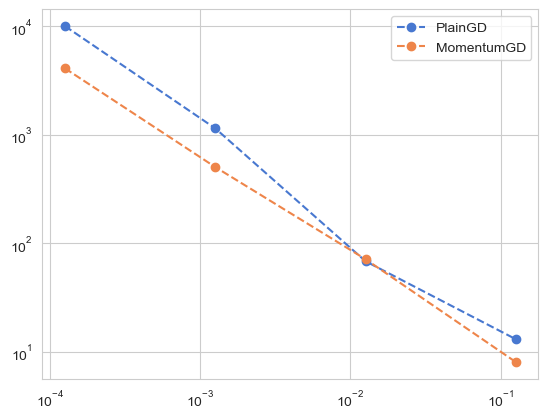

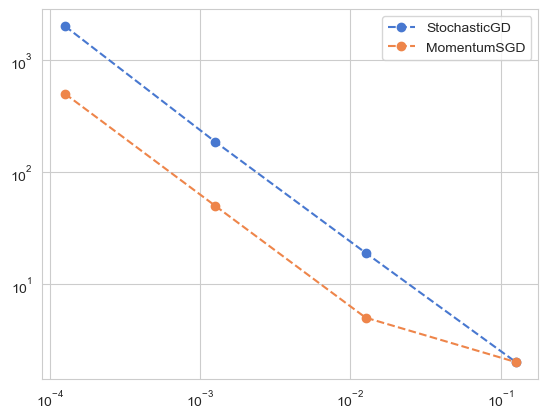

In [129]:
# No need to include these in the report - just as expected
# loglog of iterations against learning rates
#print(plain_iters, mom_iters)
plt.loglog(learning_rates, plain_iters, "o--", label="PlainGD")
plt.loglog(learning_rates, mom_iters, "o--", label="MomentumGD")
plt.legend()
plt.show()

# ... epochs against learning rates
#print(sgd_epochs, msgd_epochs)
plt.loglog(learning_rates, sgd_epochs, "o--", label="StochasticGD")
plt.loglog(learning_rates, msgd_epochs, "o--", label="MomentumSGD")
plt.legend()
plt.show()

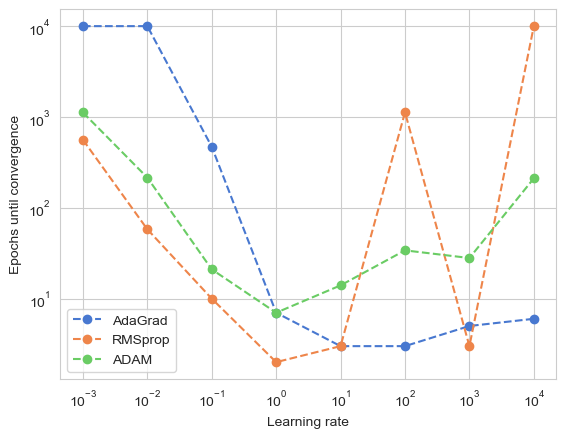

In [130]:
# With self adjusting methods
#print(adg_epochs, rms_epochs, adam_epochs)
plt.loglog(special_learning_rates, adg_epochs, "o--", label="AdaGrad")
plt.loglog(special_learning_rates, rms_epochs, "o--", label="RMSprop")
plt.loglog(special_learning_rates, adam_epochs, "o--", label="ADAM")
plt.xlabel("Learning rate")
plt.ylabel("Epochs until convergence")
plt.legend()
plt.show()

1.47, 1.08, 0.93, 0.77, 1.18, 1.19, 4.77 ms
13.0 8.0 2.0 2.0 3.0 3.0 7.0
0.1263873114780182 0.1263873114780182 0.1263873114780182 0.1263873114780182 10.0 10.0 1.0


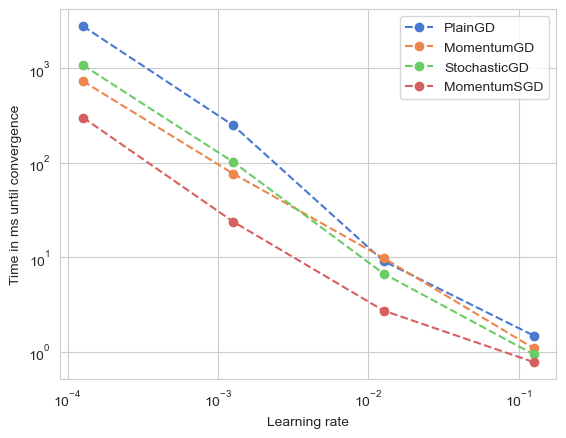

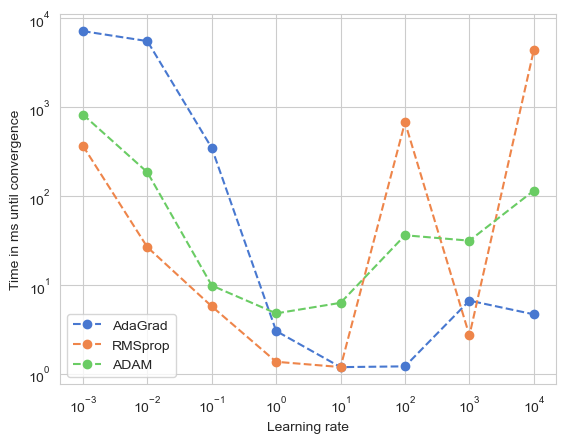

In [131]:
# Time to convergence comparison.
plain, mom, sgd, msgd, adg, rms, adam = np.argmin(plain_times), np.argmin(mom_times), np.argmin(sgd_times), np.argmin(msgd_times), np.argmin(adg_times), np.argmin(rms_times), np.argmin(adam_times)
best_times = f"{plain_times[plain]*1e3:.2f}, {mom_times[mom]*1e3:.2f}, {sgd_times[sgd]*1e3:.2f}, {msgd_times[msgd]*1e3:.2f}, {adg_times[adg]*1e3:.2f}, {rms_times[rms]*1e3:.2f}, {adam_times[adam]*1e3:.2f}"
best_iters = plain_iters[plain], mom_iters[mom], sgd_epochs[sgd], msgd_epochs[msgd], adg_epochs[adg], rms_epochs[rms], adam_epochs[adam]
best_rates = learning_rates[plain], learning_rates[mom], learning_rates[sgd], learning_rates[msgd], special_learning_rates[adg], special_learning_rates[rms], special_learning_rates[adam]
print(best_times, 'ms')
print(*best_iters)
print(*best_rates)

# Plots
plt.loglog(learning_rates, plain_times*1e3, "o--", label="PlainGD")
plt.loglog(learning_rates, mom_times*1e3,   "o--", label="MomentumGD")
plt.loglog(learning_rates, sgd_times*1e3,   "o--", label="StochasticGD")
plt.loglog(learning_rates, msgd_times*1e3,  "o--", label="MomentumSGD")
#plt.title("Time to convergence in milliseconds against learning rates")
plt.xlabel("Learning rate")
plt.ylabel("Time in ms until convergence")
plt.legend()
plt.show()

plt.loglog(special_learning_rates, adg_times*1e3,  "o--", label="AdaGrad")
plt.loglog(special_learning_rates, rms_times*1e3,  "o--", label="RMSprop")
plt.loglog(special_learning_rates, adam_times*1e3, "o--", label="ADAM")
#plt.title("Time to convergence in milliseconds against learning rates")
plt.xlabel("Learning rate")
plt.ylabel("Time in ms until convergence")
plt.legend()
plt.show()

## Hva ser vi?
Jo, ADAM er mest stabil og funker fint nesten uansett. RMS-prop er veldig ustabil, men er svært rask når epsilon er helt riktig. AdaGrad trenger veldig store epsilon for å funke (når ikke engang konvergens for "vanlige" verdier) men er aller best for høye epsilon (trenger kun én epoke!). Merk at dette er for en ekstremt enkel funksjon, så kompliserte modeller blir ikke verdsatt slik de bør.

Er noe kanksje galt når adagrad funker best med alla epsilon = 1e6? Ja... men det funker.

### For momentum SGD and AdaGrad we plot mse against iterations/epochs for selected learning rates

In [132]:
# manual mSGD
def ols_cost(X, y, theta):
    return 1/len(y) * np.dot((y - np.dot(X, theta)).T, (y - np.dot(X, theta)))

n = len(y) # datapoints
tol = 1e-9
epsilons = upper_bound_learning_rate*np.array([.001, .01, .1, 1])
k = len(epsilons)
N = 5 # number of epochs

batch_size = 16
delta = tol
cost_grad, params = OLS_grad
indices = np.arange(n)
init = np.random.randn(3)

momentum = 0.5
msgd_mse = np.zeros((k,N+1))
msgd_mse[:,0] = ols_cost(X, y, init)

for i, epsilon in enumerate(epsilons):
    theta = init
    change = 0
    for epoch in range(N):
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            batch_indices = indices[start : start+batch_size]
            Xi, yi = X[batch_indices], y[batch_indices]

            gradient = cost_grad(Xi, yi, theta, *params)
            change = epsilon*gradient + momentum*change

            theta -= change
        msgd_mse[i, epoch+1] = ols_cost(X, y, theta)

\epsilon_0 = 0.1263873114780182


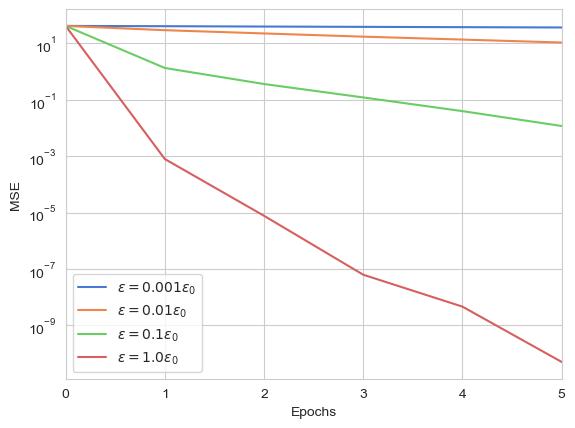

In [133]:
print(rf"\epsilon_0 = {upper_bound_learning_rate}")
for i in range(k):
    plt.plot(np.arange(N+1), msgd_mse[i], label=rf"$\epsilon = {epsilons[i]/upper_bound_learning_rate} \epsilon_0$")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.margins(x=0)
plt.legend()
plt.show()

In [148]:
# manual AdaGrad
adg_epsilons = [1, 100, 10_000, 1_000_000]
k = len(adg_epsilons)
N = 10 # number of epochs

adg_mse = np.zeros((k,N+1))
adg_mse[:,0] = ols_cost(X, y, init)

for i, epsilon in enumerate(adg_epsilons):
    theta = init # we ensure all start at the same guess
    r = 0
    for epoch in range(N):
        np.random.shuffle(indices)
        for start in range(0, n, batch_size):
            batch_indices = indices[start : start+batch_size]
            Xi, yi = X[batch_indices], y[batch_indices]

            gradient = cost_grad(Xi, yi, theta, *params)
            r = r + gradient * gradient
            change = epsilon/(delta + np.sqrt(r)) * gradient

            theta -= change
        adg_mse[i, epoch+1] = ols_cost(X, y, theta)

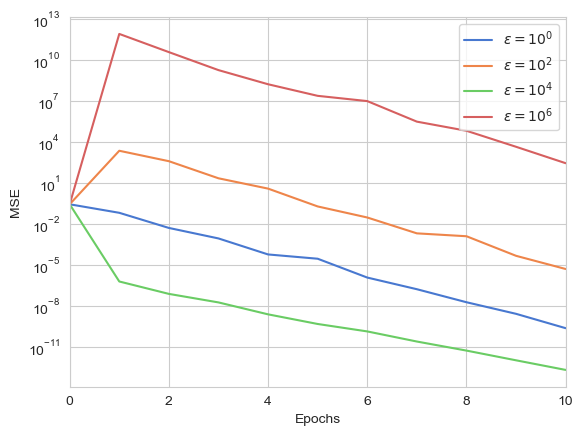

In [149]:
for i in range(k):
    plt.plot(np.arange(N+1), adg_mse[i], label=rf"$\epsilon = 10^{2*i}$")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.margins(x=0)
plt.show()

The higher learning rates are very sensitive to inital conditions: they make enourmous leaps in the first step, but then manange to recover and converge from there with no worse a slope than if they had a 'normal' learning rate. With a lucky initial leap, the high learning rates are actually the best by far converging almost immediately. IMPORTANT: we do NOT reset the accumulated gradient between epochs; then such a giant leap will be repeated at every new epoch and we do not get conergence. Such a reset thus undermines the stability of adagrad to high learning rates, and though reasonable in theory, we simply find much better results with all models (also RMSprop and ADAM) without it. 

Do note that the learning rate of 1 million gets WAY off track, jumping to 1e12. However, with other initial conditions, this model sometimes performs the best! So with high learning rates, they become unstable. A happy medium between 1 and 100 seems ideal if we have an approx. initial guess.

Når vi flytter resetten ut av hovedløkka stabiliserer gradienten seg svært fort!

## ... and Comparing With Scikit Learn

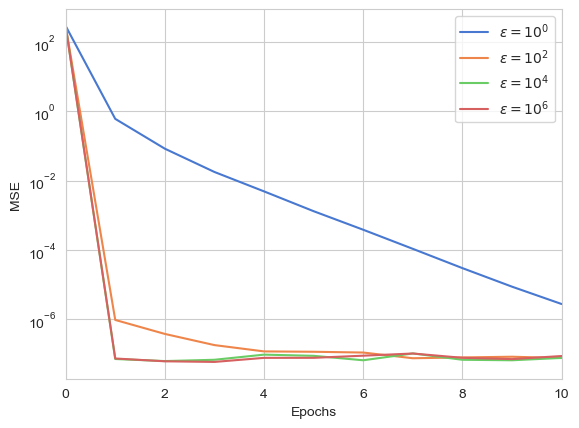

In [151]:
from sklearn.linear_model import SGDRegressor

adg_skl_mse = np.zeros((k, N+1))
adg_skl_mse[:,0] = ols_cost(X, y, init)

# Fitting "one epoch at a time"
model = SGDRegressor(learning_rate='adaptive', max_iter=1, tol=None, warm_start=True)
for i, epsilon in enumerate(adg_epsilons):
    for epoch in range(N):
        model.partial_fit(X, y)  # Update model with one epoch of data
        adg_skl_mse[i, epoch+1] = 1/len(y) * np.sum((model.predict(X) - y)**2)

for i in range(k):
    plt.plot(np.arange(N+1), adg_skl_mse[i], label=rf"$\epsilon = 10^{2*i}$")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.margins(x=0)
plt.show()


Interesting! Scikit-learn's implementation ALSO does not reset between epochs, seemingly! Note the outstanding performance of the ridiculous 1_000_000-learning rate - in fact, it only needs a SINGLE epoch to reach amazing results! Note also that this is not true SGD, since the minibatches are the full dataset (making this result more impressive and strange..). The most reasonable learning rate is actually by far the worst...

# Ridge

In [111]:
import gc # in case memory is filled by old class instances? 
for obj in gc.get_objects():
    if isinstance(obj, GradientDescent):
        del obj
gc.collect()

102895

In [112]:
# Ridge - same data as ols
llambdas = [.001, .1, 10] # logspace 100
special_learning_rates = np.array([.001,.01,.1, 1, 10, 100, 1_000, 10_000]) # do logspace ofc

# Tracking iterations/epochs and time
k = len(learning_rates)
kk = len(special_learning_rates)
kkk = len(llambdas)
plain_iters, plain_times = np.zeros((k,kkk)), np.zeros((k,kkk))
mom_iters,   mom_times   = np.zeros((k,kkk)), np.zeros((k,kkk))
sgd_epochs,  sgd_times   = np.zeros((k,kkk)), np.zeros((k,kkk))
msgd_epochs, msgd_times  = np.zeros((k,kkk)), np.zeros((k,kkk))
adg_epochs,  adg_times   = np.zeros((kk,kkk)), np.zeros((kk,kkk))
rms_epochs,  rms_times   = np.zeros((kk,kkk)), np.zeros((kk,kkk))
adam_epochs, adam_times  = np.zeros((kk,kkk)), np.zeros((kk,kkk))

eps_0s = np.zeros_like(llambdas)

I = np.eye(p+1)
XTX = X.T @ X
for j, llambda in enumerate(llambdas):
    ridge_grad = (gd.MSE_Ridge, [llambda])
    beta = np.linalg.inv(XTX + n*llambda*I) @ X.T @ y # analytical solution, including the scaling factor (n)
    
    def test_criterion(self, tol, beta=beta):
        return not np.allclose(self.theta, beta, tol)

    # Finding optimal step for the simple models
    H = 1/n*XTX + llambda*I
    EigVal, EigVec = np.linalg.eig(H)
    upper_bound_learning_rate = 1/np.max(EigVal)
    learning_rates = upper_bound_learning_rate*np.array([.001,.01,.1,1]) # logspace
    eps_0s[j] = upper_bound_learning_rate

    for i, learning_rate in enumerate(learning_rates):
        # Non-stochastic methods
        PlainGD       = GradientDescent(learning_rate, max_iter, tol=.1, momentum=0,  cost_gradient=ridge_grad, criterion=test_criterion) 
        MomentumGD    = GradientDescent(learning_rate, max_iter, tol=.1, momentum=.5, cost_gradient=ridge_grad, criterion=test_criterion)
        theta, plain_iters[i,j], plain_times[i,j] = time_fit(PlainGD)
        theta, mom_iters[i,j],   mom_times[i,j]   = time_fit(MomentumGD)
        # Stochastic methods (lower tolerance due required)
        MomentumSGD   = GradientDescent(learning_rate, epochs, tol=.1, momentum=.5, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)
        StochastichGD = GradientDescent(learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)
        theta, sgd_epochs[i,j],  sgd_times[i,j]   = time_fit(StochastichGD)
        theta, msgd_epochs[i,j], msgd_times[i,j]  = time_fit(MomentumSGD)
    print(upper_bound_learning_rate)

    for i, learning_rate in enumerate(special_learning_rates):
        AdaGrad       = AdaGradGD(learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion) # Don't ask about the factor of 1000, just admire the incredible results.
        RMSProp       = RMSPropGD(learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)
        ADAM          = ADAMGD(   learning_rate, epochs, tol=.1, cost_gradient=ridge_grad, batch_size=16, criterion=test_criterion)

        theta, adg_epochs[i,j],  adg_times[i,j]   = time_fit(AdaGrad)
        theta, rms_epochs[i,j],  rms_times[i,j]   = time_fit(RMSProp)
        theta, adam_epochs[i,j], adam_times[i,j]  = time_fit(ADAM)

    print(f"Lambda = {llambda}:")
    print(f"Analytical parameters: {beta}")

0.2527107440929814
Lambda = 0.001:
Analytical parameters: [1.00050511 1.99853078 2.99889315]
0.2465426504061371
Lambda = 0.1:
Analytical parameters: [1.03383818 1.86303897 2.89912145]
0.07165328980807605
Lambda = 10:
Analytical parameters: [0.36115077 0.23947836 0.81465456]


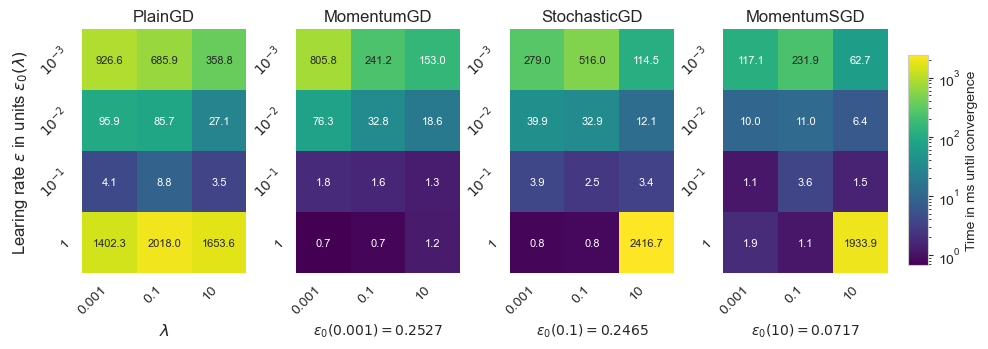

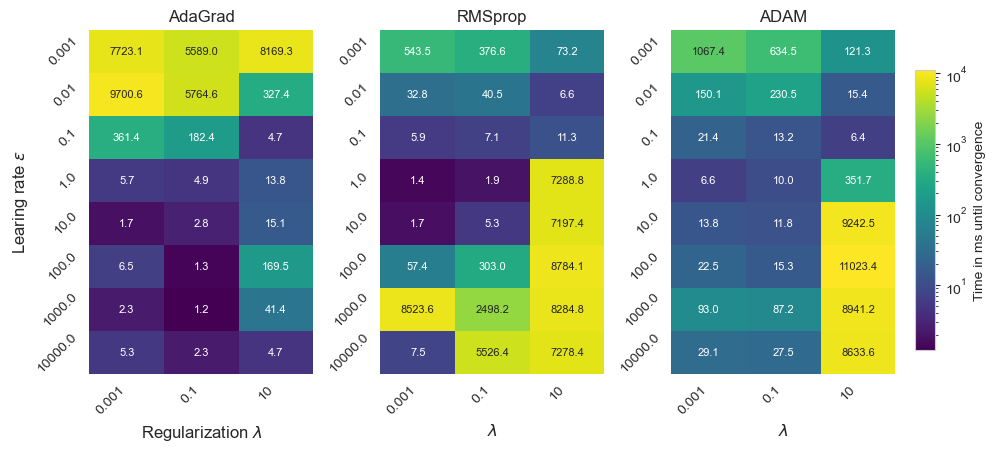

In [123]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter

# Plotting heatmaps
llambdas = [.001, .1, 10] # logspace 100
learning_rates = [.001,.01,.1,1] # times epsilon naught

frames = [plain_times*1e3, mom_times*1e3, sgd_times*1e3, msgd_times*1e3]
model = ["PlainGD", "MomentumGD", "StochasticGD", "MomentumSGD"]

# Find the global min and max for normalization
all_data = np.concatenate([frame.flatten() for frame in frames])
vmin = np.min([data.min() for data in all_data])
vmax = np.max([data.max() for data in all_data])
norm = LogNorm(vmin=vmin, vmax=vmax)

# Create figure for the larger heatmap and colorbar
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
fig.tight_layout()
fig.subplots_adjust(right=0.85, wspace=0.3) 
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])     # add axis for colorbar


# Plot each smaller heatmap in the larger heatmap cells
for idx, frame in enumerate(frames):
    # Plotting the heatmap
    sns.heatmap(frame, ax=axs[idx], cbar=(idx==0), cbar_ax=cbar_ax if (idx==0) else None, 
                norm=norm, annot=True, annot_kws={"fontsize":8}, cmap='viridis', fmt=".1f")
    
    # Adding column and row names for the heatmaps
    axs[idx].set_xticklabels(llambdas, rotation=45, ha='right')
    axs[idx].set_yticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", "1"], rotation=45, ha='right')

    # Labels
    title = axs[idx].set_title(f'{model[idx]}')
    if idx == 0:
        axs[idx].set_ylabel(r'Learing rate $\epsilon$ in units $\epsilon_0(\lambda)$', size='large')
        axs[idx].set_xlabel(r'$\lambda$', size='large')
    else: 
        axs[idx].set_xlabel(rf"$\epsilon_0 ({llambdas[idx-1]}) = {eps_0s[idx-1]:.4f}$")

# Set colorbar label
cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
cbar.set_label('Time in ms until convergence')
plt.show()


# --- Same for specials
special_frames = [adg_times*1e3, rms_times*1e3, adam_times*1e3]
special_model = ["AdaGrad", "RMSprop", "ADAM"]

# Normalization
all_data = np.concatenate([frame.flatten() for frame in special_frames])
vmin = np.min([data.min() for data in all_data])
vmax = np.max([data.max() for data in all_data])
norm = LogNorm(vmin=vmin, vmax=vmax)

# Create figure
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
fig.tight_layout()
fig.subplots_adjust(right=0.85, wspace=0.3) 
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])     # add axis for colorbar


# Plot each smaller heatmap in the larger heatmap cells
for idx, frame in enumerate(special_frames):
    # Plotting the heatmap
    sns.heatmap(frame, ax=axs[idx], cbar=(idx==0), cbar_ax=cbar_ax if (idx==0) else None, 
                norm=norm, annot=True, annot_kws={"fontsize":8}, cmap='viridis', fmt=".1f")
    
    # Adding column and row names for the heatmaps
    axs[idx].set_xticklabels(llambdas, rotation=45, ha='right')
    axs[idx].set_yticklabels(special_learning_rates, rotation=45, ha='right')

    # Labels
    title = axs[idx].set_title(f'{special_model[idx]}')
    if idx == 0:
        axs[idx].set_ylabel(r'Learing rate $\epsilon$', size='large')
        axs[idx].set_xlabel(rf'Regularization $\lambda$', size='large')
    else:
        axs[idx].set_xlabel(rf'$\lambda$', size='large')
  
# Set colorbar label
cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
cbar.set_label('Time in ms until convergence')

plt.show()

## Autograd

In [61]:
import gc
for obj in gc.get_objects():
    if isinstance(obj, GradientDescent):
        del obj
gc.collect()

9597

In [62]:
def ols_cost(X, y, theta):
    return 1/len(y) * np.dot((y - np.dot(X, theta)).T, (y - np.dot(X, theta)))
OLS_grad = (grad(ols_cost, 2), []) # derivative wrt theta

# analytical solution for comparisons
XTX = X.T @ X
beta = np.linalg.inv(XTX) @ X.T @ y
H = 2/n * XTX
EigVal, EigVec = np.linalg.eig(H) # we will cheat to find upper bound on learning rate
upper_bound_learning_rate = 1/np.max(EigVal) # note: H positive definite = positive eigenvalues
print(f"The analytical learning rate is about {upper_bound_learning_rate:.5f}")

In [63]:
# Running the OLS code again with autograd gradient instead of analytical
learning_rates = upper_bound_learning_rate*np.array([.001,.01,.1,1])
special_learning_rates = np.array([.001,.01,.1, 1, 10, 100, 1_000, 10_000])

max_iter = epochs = 10_000
def time_fit(method, test=True):
    start = timer()
    theta, iters = method.fit(X,y)
    end = timer()
    time = end - start

    if iters < max_iter and test:
        msg = f"Bad convergence: {beta} {theta} and {iters} {method})"
        assert np.allclose(theta, beta, 1e-1), msg
    
    return theta, iters, time


def test_criterion(self, tol, beta=beta):
    return not np.allclose(self.theta, beta, tol)

# Tracking iterations/epochs and time
k = len(learning_rates)
kk = len(special_learning_rates)
plain_iters, plain_times = np.zeros(k), np.zeros(k)
mom_iters,   mom_times   = np.zeros(k), np.zeros(k)
sgd_epochs,  sgd_times   = np.zeros(k), np.zeros(k)
msgd_epochs, msgd_times  = np.zeros(k), np.zeros(k)
adg_epochs,  adg_times   = np.zeros(kk), np.zeros(kk)
rms_epochs,  rms_times   = np.zeros(kk), np.zeros(kk)
adam_epochs, adam_times  = np.zeros(kk), np.zeros(kk)

for i, learning_rate in enumerate(learning_rates):
    print(i) # This is a lot (~10x) slower, so it's nice to get some updates
    # Non-stochastic methods
    PlainGD    = GradientDescent(learning_rate, max_iter, tol=.1, momentum=0,  cost_gradient=OLS_grad, criterion=test_criterion) 
    MomentumGD = GradientDescent(learning_rate, max_iter, tol=.1, momentum=.5, cost_gradient=OLS_grad, criterion=test_criterion)
    theta, plain_iters[i], plain_times[i] = time_fit(PlainGD)
    theta, mom_iters[i],   mom_times[i]   = time_fit(MomentumGD)
    # Stochastic methods (might require lower tolerance than plainGD, so the comparison is bad without using test_criterion!)
    MomentumSGD   = GradientDescent(learning_rate, epochs, tol=.1, momentum=.5, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    StochastichGD = GradientDescent(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, sgd_epochs[i],  sgd_times[i]   = time_fit(StochastichGD)
    theta, msgd_epochs[i], msgd_times[i]  = time_fit(MomentumSGD)

for i, learning_rate in enumerate(special_learning_rates):
    print(i)
    # These models tolerate higher learning rates than the analytical bound. We use Goodfellow/Bengio's recommendations for the unspecified variables.
    AdaGrad = AdaGradGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    RMSProp = RMSPropGD(learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    ADAM    = ADAMGD(   learning_rate, epochs, tol=.1, cost_gradient=OLS_grad, batch_size=16, criterion=test_criterion)
    theta, adg_epochs[i],  adg_times[i]   = time_fit(AdaGrad)
    theta, rms_epochs[i],  rms_times[i]   = time_fit(RMSProp)
    theta, adam_epochs[i], adam_times[i]  = time_fit(ADAM)

The analytical learning rate is about 0.12639
0
1
2
3
0
1
2
3
4
5
6
7


19.87, 11.99, 7.80, 42.04, 9.02, 20.81, 39.98 ms
14.0 8.0 1.0 4.0 2.0 3.0 6.0
0.1263873114780182 0.1263873114780182 0.1263873114780182 0.1263873114780182 10.0 1.0 1.0


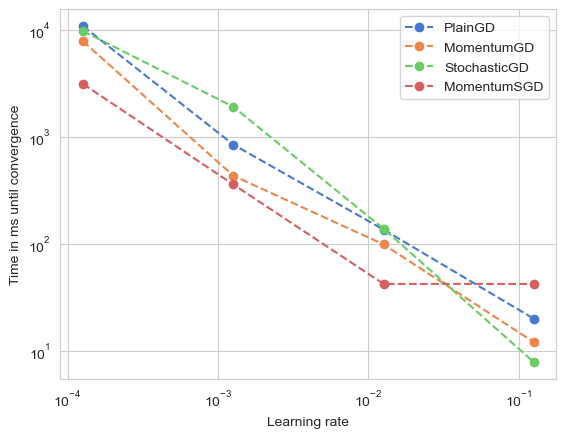

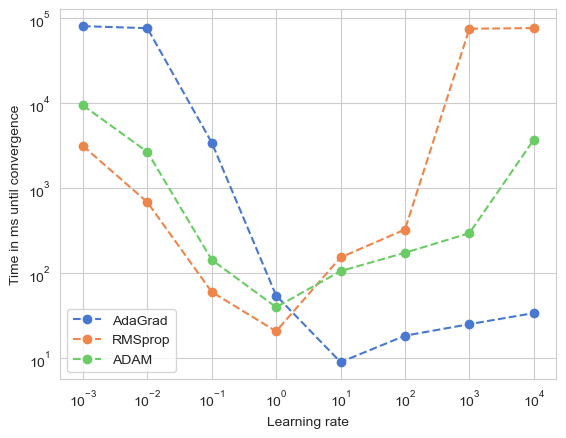

In [66]:
# Time to convergence comparison.
plain, mom, sgd, msgd, adg, rms, adam = np.argmin(plain_times), np.argmin(mom_times), np.argmin(sgd_times), np.argmin(msgd_times), np.argmin(adg_times), np.argmin(rms_times), np.argmin(adam_times)
best_times = f"{plain_times[plain]*1e3:.2f}, {mom_times[mom]*1e3:.2f}, {sgd_times[sgd]*1e3:.2f}, {msgd_times[msgd]*1e3:.2f}, {adg_times[adg]*1e3:.2f}, {rms_times[rms]*1e3:.2f}, {adam_times[adam]*1e3:.2f}"
best_iters = plain_iters[plain], mom_iters[mom], sgd_epochs[sgd], msgd_epochs[msgd], adg_epochs[adg], rms_epochs[rms], adam_epochs[adam]
best_rates = learning_rates[plain], learning_rates[mom], learning_rates[sgd], learning_rates[msgd], special_learning_rates[adg], special_learning_rates[rms], special_learning_rates[adam]
print(best_times, 'ms')
print(*best_iters)
print(*best_rates)

# Plots
plt.loglog(learning_rates, plain_times*1e3, "o--", label="PlainGD")
plt.loglog(learning_rates, mom_times*1e3,   "o--", label="MomentumGD")
plt.loglog(learning_rates, sgd_times*1e3,   "o--", label="StochasticGD")
plt.loglog(learning_rates, msgd_times*1e3,  "o--", label="MomentumSGD")
#plt.title("Time to convergence in milliseconds against learning rates")
plt.xlabel("Learning rate")
plt.ylabel("Time in ms until convergence")
plt.legend()
plt.show()

plt.loglog(special_learning_rates, adg_times*1e3,  "o--", label="AdaGrad")
plt.loglog(special_learning_rates, rms_times*1e3,  "o--", label="RMSprop")
plt.loglog(special_learning_rates, adam_times*1e3, "o--", label="ADAM")
#plt.title("Time to convergence in milliseconds against learning rates")
plt.xlabel("Learning rate")
plt.ylabel("Time in ms until convergence")
plt.legend()
plt.show()

We see the same trends here, indicating that our implementation is correct. Note that autograd uses at least 10x more time, as is the price of shorter implementation time.

In [ ]:
# Run exactly the same code as above with ridge grad as cost function
def ridge_cost(X, y, theta, llambda):
    return 1/len(y) * X.T @ (X @ (theta) - y) + llambda*theta
for lmb in llambdas:
    ridge_grad = (grad(ridge_cost, 2), [lmb]) # derivative wrt theta
    # ... exactly same as before with ridge using now this cost function, we omit this.